## Z-Image Pipeline

Executed on: Kaggle.com

**References:**

* [Z-Image — GitHub](https://github.com/Tongyi-MAI/Z-Image/tree/main)
* [Z-Image — Hugging Face Documentation](https://huggingface.co/docs/diffusers/main/en/api/pipelines/z_image)
* [Z-Image-Turbo — Hugging Face Model](https://huggingface.co/Tongyi-MAI/Z-Image-Turbo)


In [1]:
!nvidia-smi

Fri Jan 16 06:09:26 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -U transformers -q
!pip install -U accelerate -q # for distributed inference
!pip install -U peft -q
# We need to install from source as it is not currenlty in the released version as of 14 Jan 2026
!pip install git+https://github.com/huggingface/diffusers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 94.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 8.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 10.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch
from diffusers import ZImagePipeline

# Empty the cuda cache (sometime it needs the gc to flush it)
import gc
torch.cuda.empty_cache()
gc.collect()

2026-01-16 06:10:30.252217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768543830.456110      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768543830.514655      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768543831.018495      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768543831.018538      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768543831.018540      55 computation_placer.cc:177] computation placer alr

0

### Load the Z-Image-Turbo
- If we do `torch_dtype=float16` if GPU doesnot support the `torch,bfloat16`. It gives full black image.

In [4]:
# 1. Load the pipeline
# Use bfloat16 for optimal performace on supported GPUs
pipe = ZImagePipeline.from_pretrained(
    "Tongyi-MAI/Z-Image-Turbo",
    torch_dtype=torch.bfloat16,
    device_map="balanced",
    max_memory={0: "16GB", 1: "16GB"}
)

model_index.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

text_encoder/model-00003-of-00003.safete(…):   0%|          | 0.00/99.6M [00:00<?, ?B/s]

text_encoder/model-00002-of-00003.safete(…):   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

text_encoder/model-00001-of-00003.safete(…):   0%|          | 0.00/3.96G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/4.67G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.97G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.97G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# pipe.transformer.set_attention_backend("flash")
# pipe.transformer.compile()

In [6]:
prompt = "Young Chinese woman in red Hanfu, intricate embroidery. Impeccable makeup, red floral forehead pattern. Elaborate high bun, golden phoenix headdress, red flowers, beads. Holds round folding fan with lady, trees, bird. Neon lightning-bolt lamp (⚡️), bright yellow glow, above extended left palm. Soft-lit outdoor night background, silhouetted tiered pagoda (西安大雁塔), blurred colorful distant lights."

  0%|          | 0/9 [00:00<?, ?it/s]

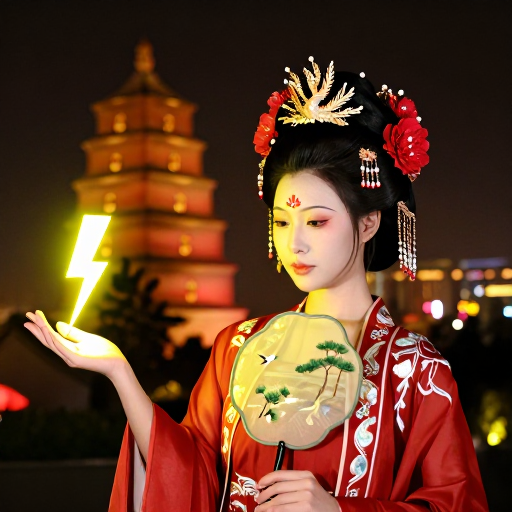

In [7]:
# 2. Generate Image
image = pipe(
    prompt=prompt,
    height=512, # 1024,
    width=512,  # 1024,
    num_inference_steps=9, # This actually results in 8 DiT forwards
    guidance_scale=1.8,    # Guidance should be 0 for the Turbo models
    generator=torch.Generator("cuda").manual_seed(43),
).images[0]

image